# Decoder Only Transformer

In [1]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from tqdm import tqdm
from transformers import BertModel, BertTokenizer

stop=set(stopwords.words('english'))

batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
eval_iters = 500
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.2
epochs = 10

/raid/home/ritwikm/miniconda3/envs/trans/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'cuda:1'

In [3]:
torch.cuda.empty_cache()

In [4]:
torch.cuda.mem_get_info()

(2518810624, 42298834944)

In [5]:
data = ""
for i in tqdm(range(1,8)):
    with open(f"harry/{i}.txt", "r") as f:
        data += f.read()

data[:100]

100%|██████████| 7/7 [00:00<00:00, 590.27it/s]


'M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly norm'

In [6]:
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt2")
vocab_size = enc.n_vocab
encoded_data = enc.encode(data)

In [7]:
# def remove_URL(text):
#     url = re.compile(r'https?://\S+|www\.\S+')
#     return url.sub(r'',text)
# def remove_html(text):
#     html=re.compile(r'<.*?>')
#     return html.sub(r'',text)
# def remove_punct(text):
#     table=str.maketrans('','',string.punctuation)
#     return text.translate(table)

# def create_corpus(df):
#     corpus=[]
#     # for tweet in tqdm(df):
#     dd = word_tokenize(df)
#     filtered = [w for w in dd if not w in stopwords.words('english')]
#     # words=[word.lower() for word in word_tokenize(df) if((word.isalpha()==1) & (word not in stop))]
#     # corpus.append(words)
#     corpus.append(filtered)
#     str1 = ' '.join(corpus[0])
#     return str1

# data_clean = remove_URL(data)
# data_clean = remove_html(data_clean)
# data_clean = remove_punct(data_clean)
# # data_clean = create_corpus(data_clean)

# from transformers import AutoTokenizer

# # spacy_english = spacy.load('en_core_web_sm')
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# encoded_data = []
# # tokenizer.encode( data , padding=True)
# for i in tqdm(range(0, len(data_clean), 512)):
#     encoded_data += (tokenizer.encode(data_clean[i:i+512], padding=True))

# print(len(encoded_data))

# vocab_size = tokenizer.vocab_size

In [8]:
len(encoded_data)

1669290

In [9]:
# here are all the unique characters that occur in this text
# chars = sorted(list(set(data)))
# # vocab_size = len(chars)
# # create a mapping from characters to integers
# stoi = { ch:i for i,ch in enumerate(chars) }
# itos = { i:ch for i,ch in enumerate(chars) }
# encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Gelu Activation 

## Formulae
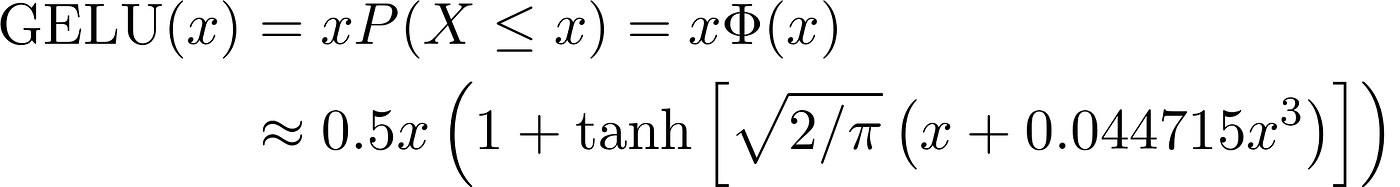

## Comparision with Relu
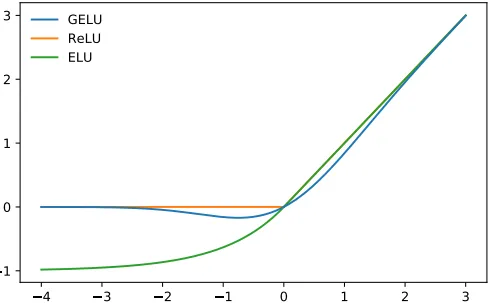

In [10]:
class Gelu(nn.Module):
    def forward(self, x):
        return 0.5*x*(1 + torch.tanh(np.sqrt(2/np.pi)*(x + 0.044715*torch.pow(x,3))))

In [11]:
# data = torch.tensor(encode(data), dtype=torch.long)
data = torch.tensor(encoded_data, dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [12]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train = torch.tensor(encoded_data[:int(len(encoded_data)*0.9)], dtype=torch.long)
# val = torch.tensor(encoded_data[int(len(encoded_data)*0.9):], dtype=torch.long)
# # train.to(device)
# # val.to(device)
# print(train.shape, val.shape)



# class TextDataSet(Dataset):
#     def __init__(self, tokens: list[int], sequence_size = block_size, stride = 1, device = 'cpu'):
#         # self._tokenizer = tokenizer
#         self._input_ids = []
#         self._target_ids = []

#         token_length = len(tokens)

#         for i in range(0, token_length - sequence_size, stride):
#             input_chunk = tokens[i:i + sequence_size]
#             target_chunk = tokens[i + 1: i + sequence_size + 1]

#             self._input_ids.append(torch.tensor(input_chunk).to(device))
#             self._target_ids.append(torch.tensor(target_chunk).to(device))

#     def __len__(self):
#         return len(self._input_ids)

#     def __getitem__(self, idx):
#         return self._input_ids[idx], self._target_ids[idx]
    

# text_data_set = TextDataSet(train, device=device)
# val_data_set = TextDataSet(val, device=device)

# training_data_loader = DataLoader(text_data_set, batch_size=batch_size, 
#                           shuffle=False, drop_last=True)
# validation_data_loader = DataLoader(val_data_set, batch_size=batch_size,
#                             shuffle=False, drop_last=True)

In [13]:
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self,max_seq_len=block_size,d_model=n_embd) -> None:
        super(PositionalEncoding,self).__init__()
        self.d_model = d_model
        # self.encoding = torch.zeros(max_seq_len, d_model, device=device)
        pos = torch.arange(0, max_seq_len,dtype = torch.float).unsqueeze(1)
        # we know a^-x  is equals to 1/a^x
        frequency = torch.pow(10000,-torch.arange(0,d_model,2,dtype = torch.float)/self.d_model)
        self.pe = torch.zeros((max_seq_len,d_model))
        self.pe[:,0::2] = torch.sin(pos * frequency)
        self.pe[:,1::2] = torch.cos(pos * frequency)
        # Here we use register_buffer, because it avoid update model parameter during backpropagation
        # self.register_buffer('pe', self.pe)
    def forward(self, x):
        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]
        return self.pe[:seq_len, :]

In [15]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.out = nn.Linear(head_size, n_embd)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        self.dropGelu = Gelu()
    
    def forward(self, x):
        B,T,C = x.shape           
        q = self.query(x)
        k = self.key(x)

        attn = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(n_embd))
        attn = attn.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        # attn = self.dropGelu(attn)

        v = self.value(x)
        out = attn @ v

        return out
        

## Diffrential Transformer

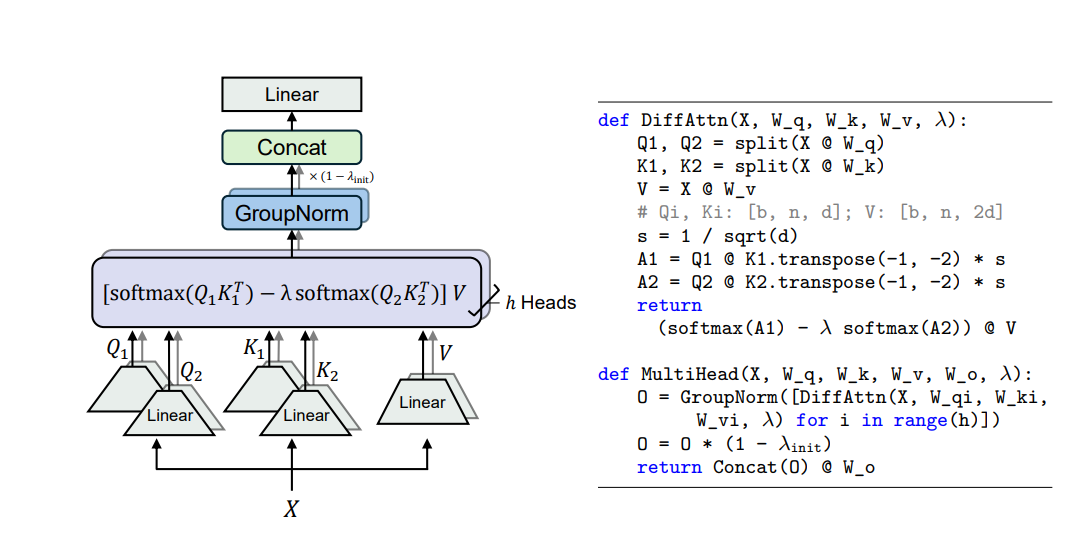

In [16]:
x = torch.randn(32, block_size, n_embd)

In [17]:
import math

def lambda_init_fn(depth=n_layer):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)

class DiffAttn(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.out = nn.Linear(head_size, n_embd)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, lam):
        q1, q2 = torch.chunk(self.query(x), 2, dim=-1)
        k1, k2 = torch.chunk(self.key(x), 2, dim=-1)
        v = self.value(x)

        s = 1/np.sqrt(n_embd/2)

        a1 = (q1 @ k1.transpose(-2, -1)) * s
        a2 = (q2 @ k2.transpose(-2, -1)) * s
        # attn = attn.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        # attn = attn.masked_fill(self.tril[:T, :T] == 0, float('-inf'))


        return (F.softmax(a1, dim=-1) - lam * F.softmax(a2, dim=-1)) @ v 
    
class MultiDiffAttn(nn.Module):
    def __init__(self, head_size, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([DiffAttn(head_size) for _ in range(n_heads)])
        self.norm = nn.GroupNorm(n_heads, n_embd)
        
    def forward(self, x, lam):
        O = torch.cat([h(x, lam) for h in self.heads], dim=-1)
        lam = lambda_init_fn()
        O = O * (1 - lam)
        return 
        


In [18]:
import math
import torch
import torch.nn.functional as F
from torch import nn

from .kernel.rotary import apply_rotary_emb
from flash_attn import flash_attn_func
try:
    from apex.normalization import FusedRMSNorm as RMSNorm 
except ModuleNotFoundError:
    print("No fused RMSNorm")
    from .rms_norm import RMSNorm


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        args,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.args = args
        self.embed_dim = embed_dim
        
        # arg num_heads set to half of Transformer's num_heads
        self.num_heads = num_heads
        
        # arg decoder_kv_attention_heads set to half of Transformer's num_kv_heads if use GQA
        # set to same as num_heads if use normal MHA
        self.num_kv_heads = args.decoder_kv_attention_heads if args.decoder_kv_attention_heads is not None else num_heads
        self.n_rep = self.num_heads // self.num_kv_heads
        
        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5
        
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)
    
    def forward(
        self,
        x,
        rel_pos,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = apply_rotary_emb(q, *rel_pos, interleaved=True)
        k = apply_rotary_emb(k, *rel_pos, interleaved=True)

        offset = src_len - tgt_len
        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        if attn_mask is None:
            attn_mask = torch.triu(
                torch.zeros([tgt_len, src_len])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += attn_mask   
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] - lambda_full * attn_weights[:, :, 1]
        
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)

        attn = self.out_proj(attn)
        return attn

ImportError: attempted relative import with no known parent package

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.multi = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.out = nn.Linear(num_heads*head_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.dropGelu = Gelu()

    def forward(self, x):
        out1 = torch.cat([m(x) for m in self.multi], dim=-1)
        # out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.out(out1))
        # out = self.dropGelu(self.out(out1))
        return out

In [20]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.l1 = nn.Linear(n_embd, 2*n_embd)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(2*n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.dropGelu = Gelu()

    def forward(self, x):
        out = self.l1(x)
        out = self.dropGelu(out)
        # out = self.relu(out)
        out = self.l2(out)
        out = self.dropout(out)
        # out = self.dropGelu(out)
        return out

In [21]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.d_k = n_embd//n_head
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mha = MultiHeadAttention(n_head, self.d_k)
        self.ff = FeedForward(n_embd)
    
    def forward(self, x):
        out = self.mha(self.ln1(x))
        out = out + x
        out = self.ff(self.ln2(out))
        out = out + x
        return out    

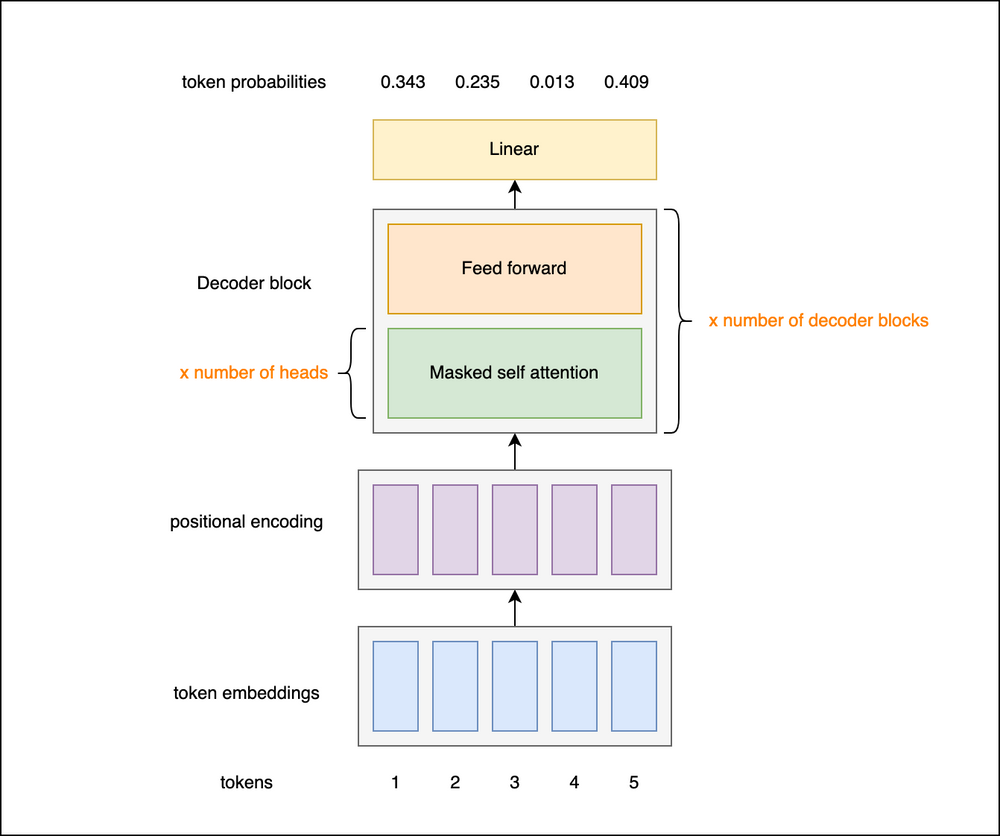

[text](https://wingedsheep.com/building-a-language-model/)

In [22]:
pos_embw = nn.Embedding(block_size, n_embd)
pos_emb = pos_embw(torch.arange(block_size))
pos_emb.shape

torch.Size([256, 512])

In [23]:
class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.pos_emb_2 = PositionalEncoding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            # nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        # if isinstance(module, nn.Embedding):
        #     torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.tok_emb(idx) # (B,T,C)
        # pos_emb = self.pos_emb(torch.arange(T, device=device)) # (T,C)
        pos_emb = self.pos_emb_2(idx).to(device) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            # print(idx_cond.shape)
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [25]:
import os
model = GPTModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
learning_rate = 3e-4
# from torch import optim
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    patience=5,
                                                    factor=0.1,
                                                    min_lr=1e-6,)

for iter in tqdm(range(max_iters)):
    # print(f"iter {iter} || lr {optimizer.param_groups[0]['lr']:.2E}")
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"lr {optimizer.param_groups[0]['lr']:.2E}")

    # scheduler.step(loss)
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    nn.utils.clip_grad_norm_(m.parameters(),1)
    optimizer.step()
    if iter % 1000 == 0:
        if os.path.exists('model.pth'):
            torch.save(m.state_dict(), 'model_2.pth')



65.859665 M parameters
step 0: train loss 10.9144, val loss 10.9096
lr 3.00E-04
step 500: train loss 4.5717, val loss 4.7878
lr 3.00E-04
step 1000: train loss 3.9683, val loss 4.3714
lr 3.00E-04
step 1500: train loss 3.6770, val loss 4.2007
lr 3.00E-04
step 2000: train loss 3.4485, val loss 4.1124
lr 3.00E-04


KeyboardInterrupt: 

In [26]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(enc.decode(m.generate(context, max_new_tokens=256)[0].tolist()))

!”

“Shut up here with it and see what,” said Wood, and the figure of away as they came on back. “Yes! It was that about you were funny. Potter told me that, is the boy who call that Lord Voldemorts Bagman!”

Snape had broke. She did not have showed him to him why it was to Dumbledore.

“One afternoon!” gasped the Prime Minister, nodded. “We each Halloween is murder or last time on the bar, the Department of Magic’s equals! So it’s right, bit it is retiring. And Harry Potterish matters on it tomorrow, sit far in the place where he would blow, I can chew. Ensure it would be the same well what was shows him seriously going on …”

On laundry needles, as he pulled out Mundungus on him’s bag and began to stare at Harry.

“Yeah, Dad prefect, they’re as wet! You might never have a poor gasp of the rest of tokens!” cried Mrs. Weasley. “I am trained tea, train mean, you have just done. You thought I wouldn


In [35]:
context

tensor([[0]], device='cuda:1')

In [27]:
q = "Who are ron and hermione ?"
token = torch.tensor(enc.encode(q)).unsqueeze(0).to(device)
print(token)
print(enc.decode(m.generate(token, max_new_tokens=256)[0].tolist()))

tensor([[8241,  389,  374,  261,  290,  607,   76, 7935, 5633]],
       device='cuda:1')
Who are ron and hermione ? How “

“Got it somewhere,” said Mr. Weasley, clicking Harry. “So you are - and collecting various – It”

“Yes,” said Angelina tearly, as though just anyone flew into Lupin’s steak to grin as they dragged across the train-up that read their armour upon Filch.

“But, there’s no hex,” said Hermione. “He wants to try door, don’t know. . . no, how do he’re feeling, eh again? They’re the only there! Leaky Catterarcered, but thanks You can tell you my sister — a spell —”

“That’s not a – your cousin,” Hagrid said.

“Don’t F blamein’ see whether Tonks’ me, they come easily!”

“I don’t think! I care, didn’t great need to times,” said Hermione, waving at Dudley. “Well — we do, like having platforms Transfiguration appearcardy” she swear her interrupt she
